In [ ]:
!pip install kaggle

In [ ]:
!pip install seaborn

In [ ]:
!pip install pandas numpy scikit-learn nltk tqdm keras tensorflow pyemd --upgrade gensim


In [23]:
!pip install tensorflow

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt

In [45]:
!pip uninstall numpy -y
!pip install numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [3]:
import seaborn as sns
pal = sns.color_palette()


In [43]:
!pip install --upgrade pandas


# Setup Dataset

In [ ]:
! mkdir ~/.kaggle

In [8]:
!mv /../kaggle.json ~/.kaggle

In [ ]:
!kaggle competitions download -c quora-question-pairs

In [ ]:
!unzip quora-question-pairs.zip

In [38]:
#!unzip sample_submission.csv.zip
!rm sample_submission.csv.zip

In [32]:
!mkdir submission
!mv test.csv submission
!mv sample_submission.csv submission

mkdir: cannot create directory ‘submission’: File exists


In [39]:
!rm quora-question-pairs.zip

In [ ]:
!unzip test.csv.zip
!rm test.csv.zip
!unzip train.csv.zip
!rm train.csv.zip

# Analysis

In [ ]:
from csv

In [4]:
df_train = pd.read_csv('../content/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df_train = df_train.dropna()

<Axes: xlabel='is_duplicate'>

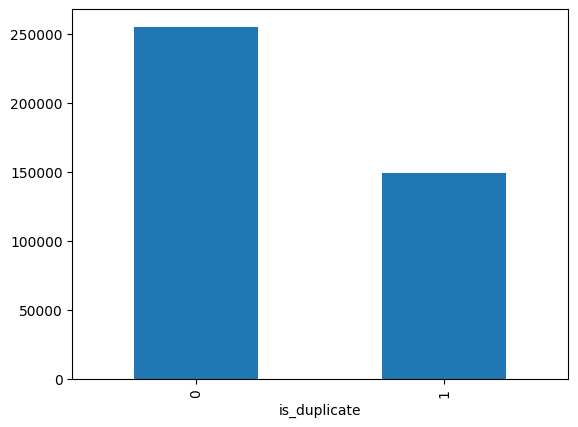

In [ ]:
df_train.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
dfq1, dfq2 = df_train[['qid1', 'question1']], df_train[['qid2', 'question2']]

In [ ]:
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
diff_encodings = np.abs(mq1[::2] - mq1[1::2])


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



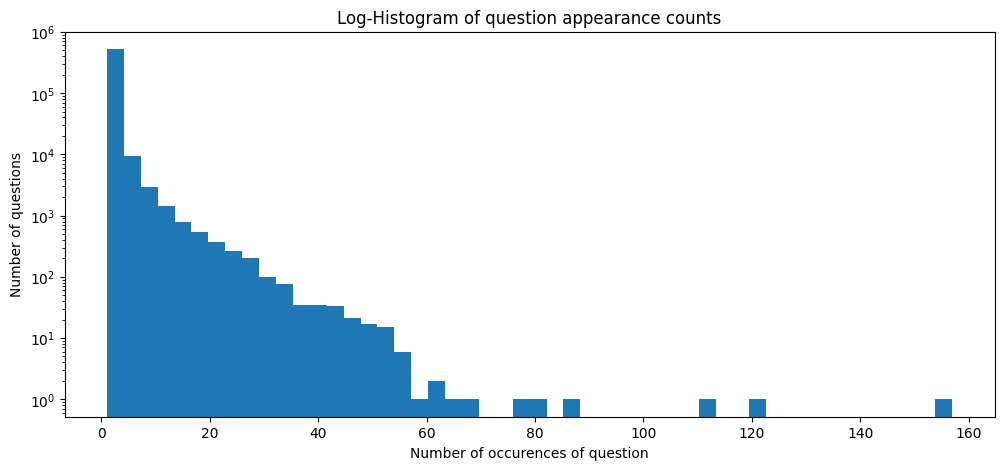

In [ ]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [ ]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('../content/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()


Predicted score: 0.6585273839844354


<ipython-input-11-4e7652b54a2d>:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('../content/test.csv')


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.63 max-train 1169.00 max-test 1176.00


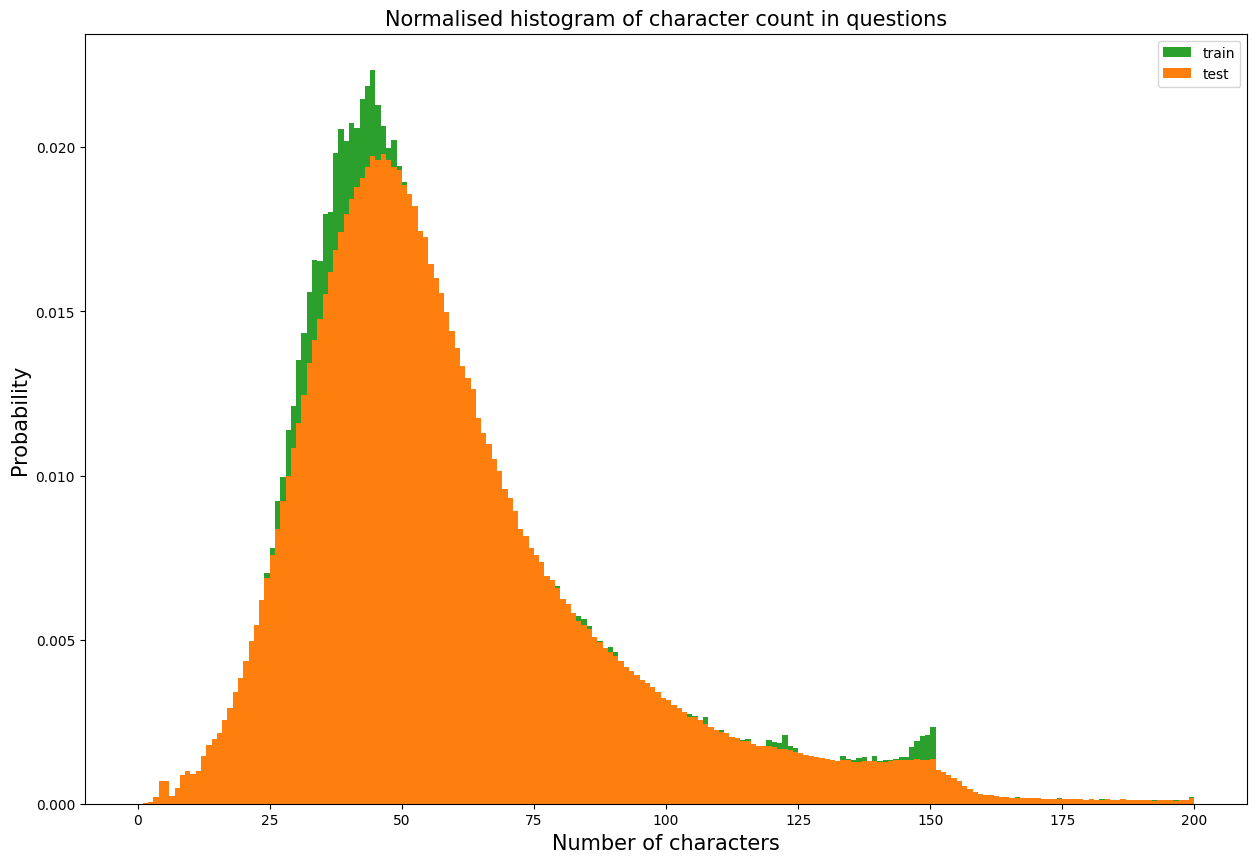

In [ ]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], density=True, alpha=1, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(),
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))


mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


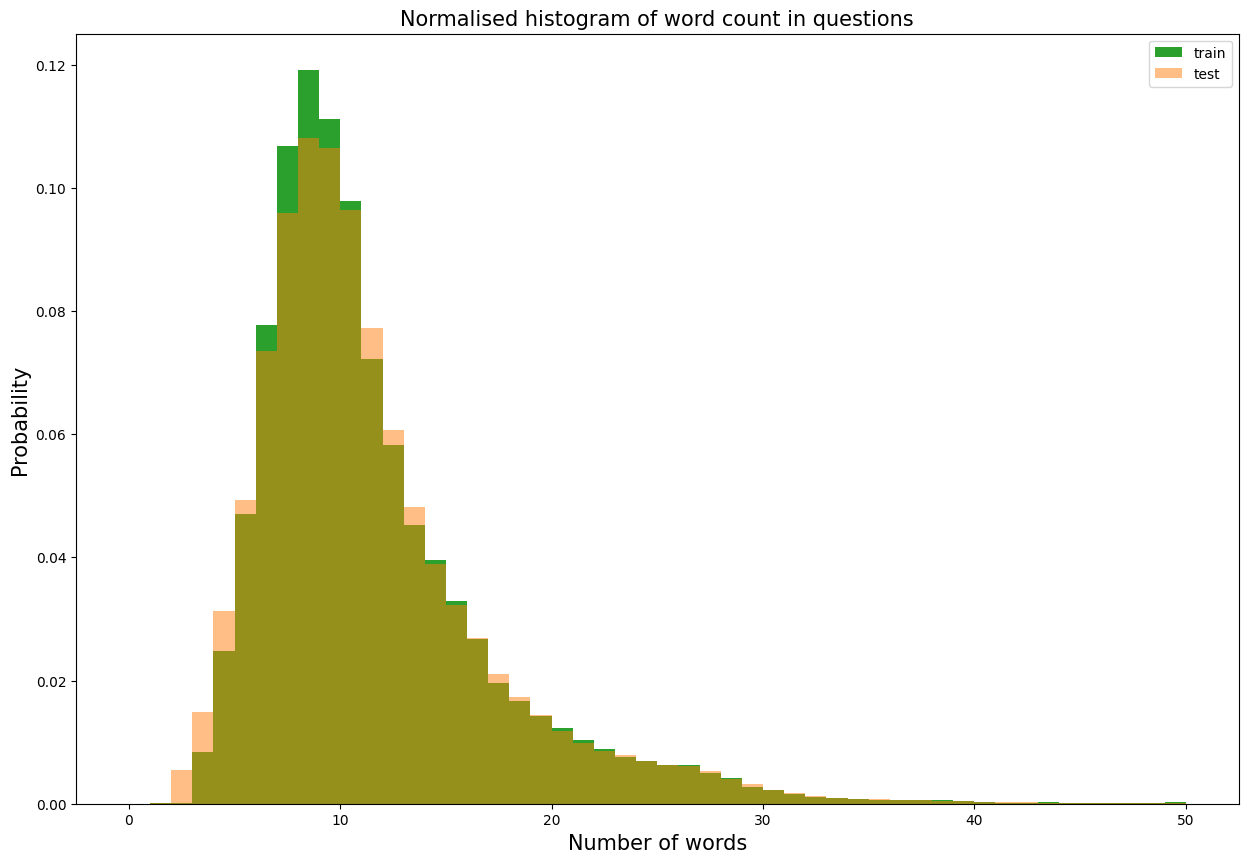

In [ ]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(),
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))


(-0.5, 1439.5, 1079.5, -0.5)

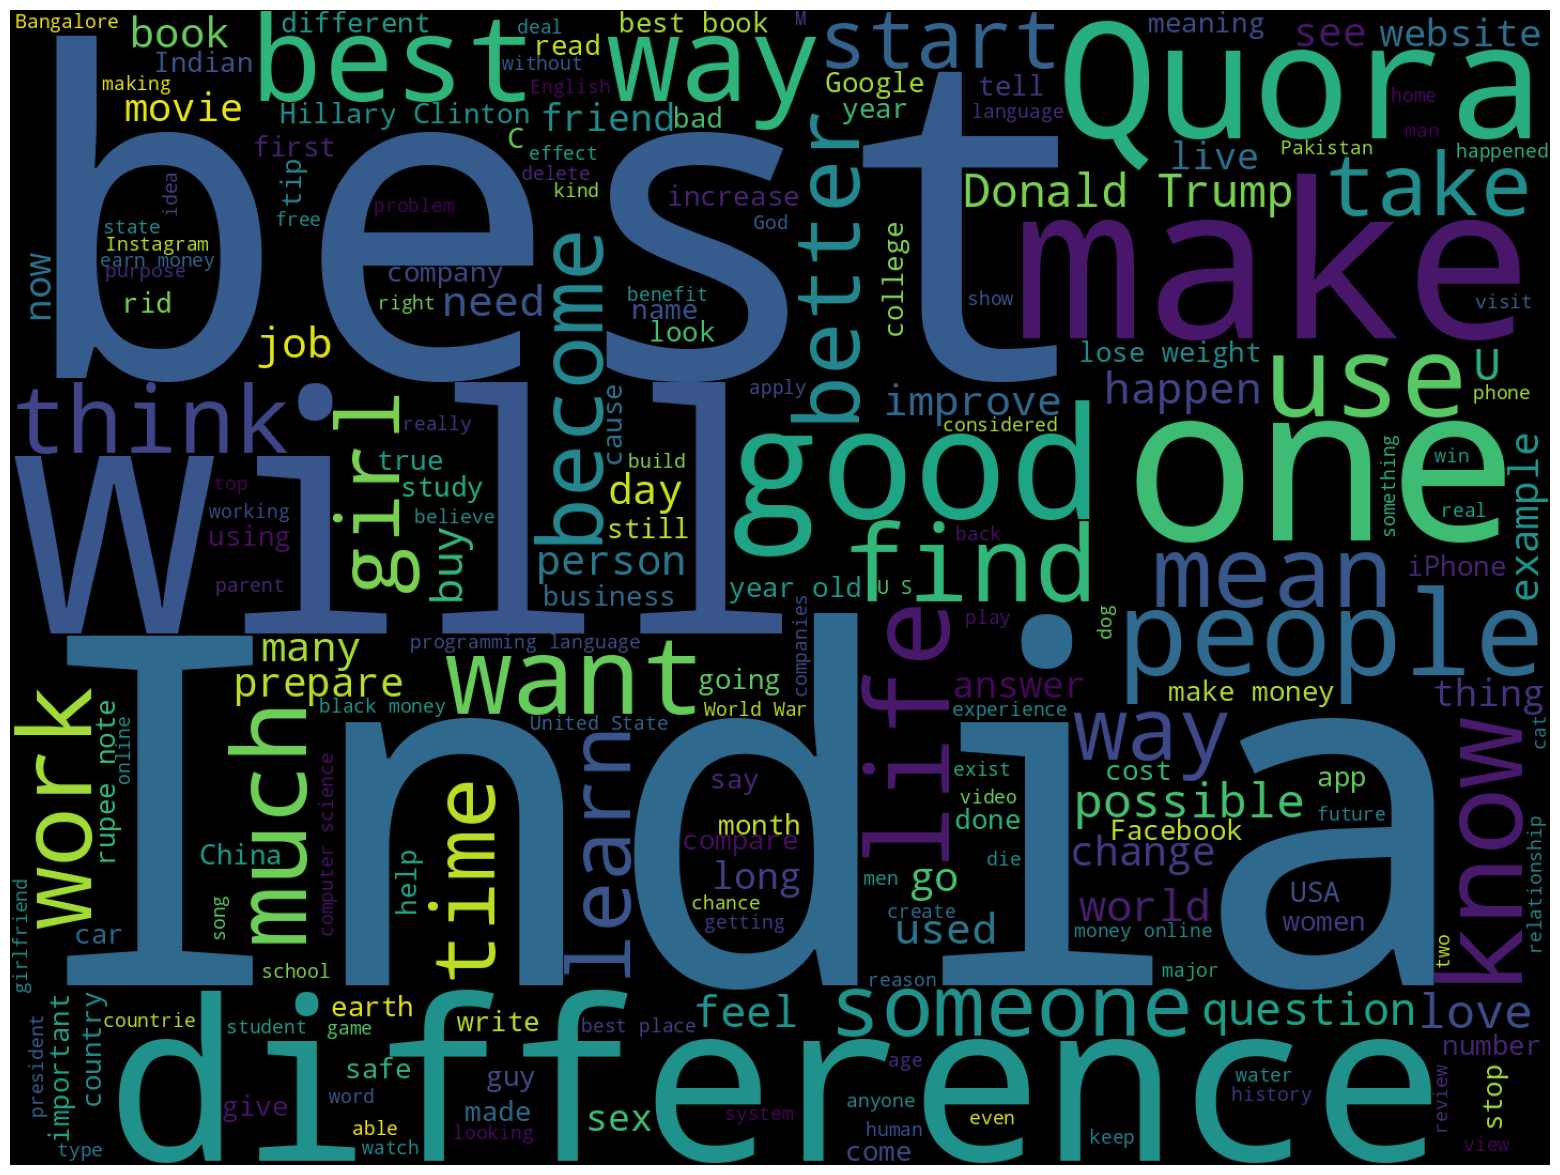

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from copy import deepcopy
data = deepcopy(df_train)

In [ ]:
#import cPickle
import pandas as pd
import numpy as np
import gensim
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize
stop_words = stopwords.words('english')

In [ ]:
data = data.drop(['id', 'qid1', 'qid2'], axis=1)


data['len_q1'] = data.question1.apply(lambda x: len(str(x)))
data['len_q2'] = data.question2.apply(lambda x: len(str(x)))
data['diff_len'] = data.len_q1 - data.len_q2
data['len_char_q1'] = data.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
data['len_char_q2'] = data.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
data['len_word_q1'] = data.question1.apply(lambda x: len(str(x).split()))
data['len_word_q2'] = data.question2.apply(lambda x: len(str(x).split()))
data['common_words'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)


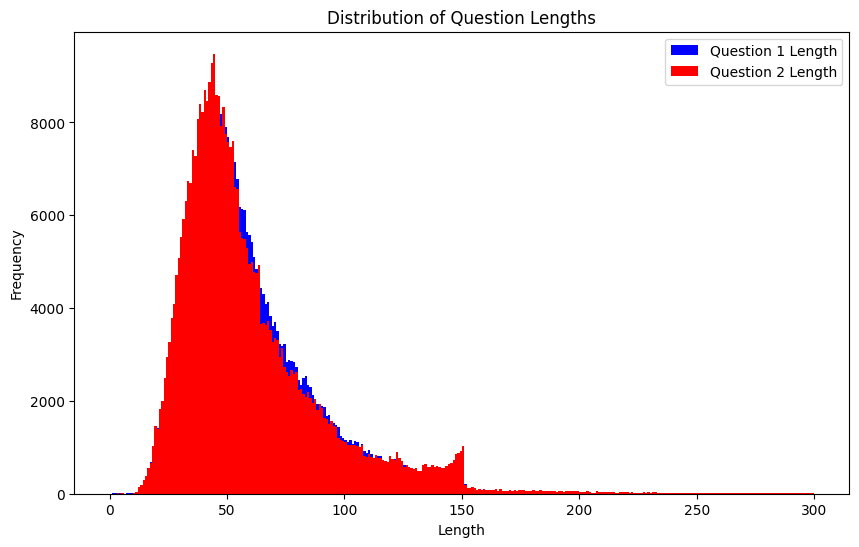

In [ ]:

# Plotting distribution of length of question 1 and question 2
plt.figure(figsize=(10, 6))
plt.hist(data=data, x='len_q1', color='blue', label='Question 1 Length', range=[0,300], bins=300)
plt.hist(data=data, x='len_q2', color='red', label='Question 2 Length', range=[0,300], bins=300)
plt.title('Distribution of Question Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()



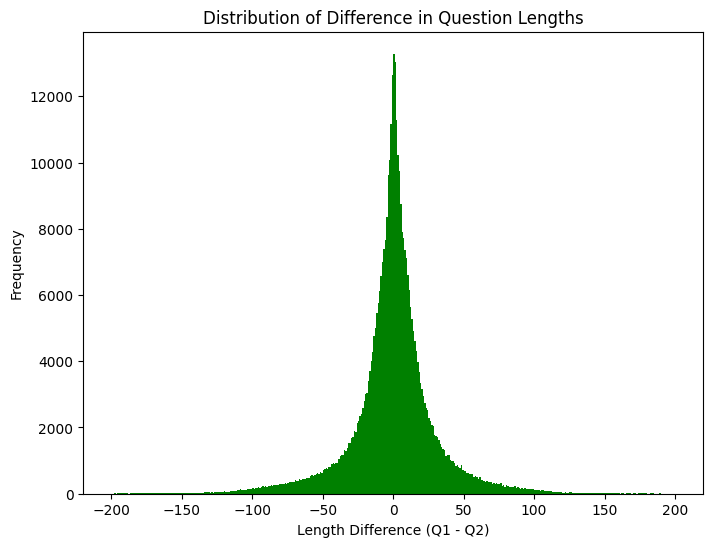

In [ ]:
# Plotting distribution of difference in length between question 1 and question 2
plt.figure(figsize=(8, 6))
plt.hist(data=data, x='diff_len', color='green', range=[-200,200], bins=400)
plt.title('Distribution of Difference in Question Lengths')
plt.xlabel('Length Difference (Q1 - Q2)')
plt.ylabel('Frequency')
plt.show()



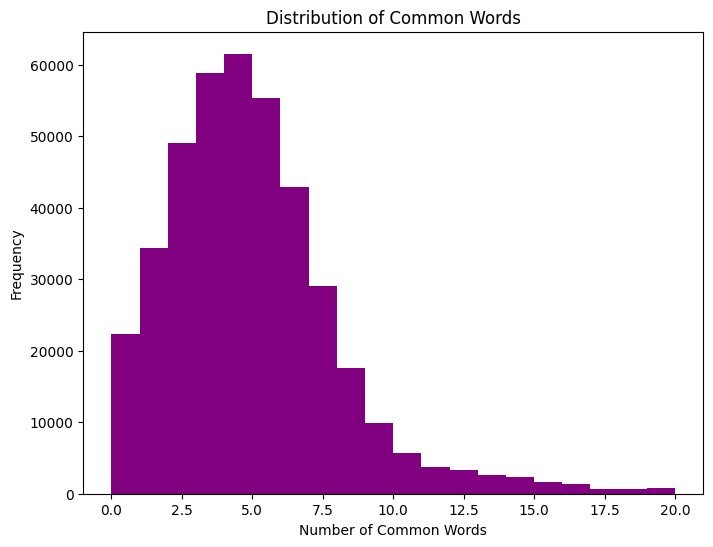

In [ ]:

# Plotting distribution of common words between question 1 and question 2
plt.figure(figsize=(8, 6))
plt.hist(data=data, x='common_words', color='purple', range=[0,20], bins=20)
plt.title('Distribution of Common Words')
plt.xlabel('Number of Common Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:

# Plotting distribution of various fuzzy matching ratios
plt.figure(figsize=(10, 6))
sns.histplot(data=data[['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio']], bins=50, multiple='stack')
plt.title('Distribution of Fuzzy Matching Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Frequency')
plt.legend(['fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio'])
plt.show()

NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
data.to_csv('feature_engineered_train.csv', index=False)

# Creating Embeddings

### Word2Vec

In [ ]:
!kaggle datasets download -d leadbest/googlenewsvectorsnegative300

100% 3.17G/3.17G [00:44<00:00, 103MB/s] 
100% 3.17G/3.17G [00:44<00:00, 76.2MB/s]


In [ ]:
!unzip googlenewsvectorsnegative300.zip

Archive:  googlenewsvectorsnegative300.zip
  inflating: GoogleNews-vectors-negative300.bin  
  inflating: GoogleNews-vectors-negative300.bin.gz  


In [ ]:
!rm googlenewsvectorsnegative300.zip

In [ ]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format("../content/GoogleNews-vectors-negative300.bin", binary=True)

In [11]:
df_test = pd.read_csv("../content/test.csv")

<ipython-input-11-b16972f3fa8a>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("../content/test.csv")


In [12]:
df_test.dropna()
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Convert text to a word list

In [9]:
x = pd.read_csv('../content/submission/test.csv')

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


In [27]:
def tokenize(s):
    tokens = []
    tokens = [word_tokenize(str(sentence)) for sentence in s]

    rm1 = []
    for w in tokens:
        sm = re.sub('[^A-Za-z]',' ', str(w))
        x = re.split("\s", sm)
        rm1.append(x)

    return rm1


In [28]:
def lower_case(s):
    #Removing whitespaces
    for sent in s:
        while '' in sent:
            sent.remove('')

    # Lowercasing
    low = []
    for i in s:
        i = [x.lower() for x in i]
        low.append(i)

    return low



In [29]:
def lemmatize(s):
    lemma = []
    wnl = WordNetLemmatizer()
    for doc in s:
        tokens = [wnl.lemmatize(w) for w in doc]
        lemma.append(tokens)

    # Removing Stopwords
    filter_words = []
    Stopwords = set(stopwords.words('english'))

    #ab = spell('nd')
    for sent in lemma:
        tokens = [w for w in sent if w not in Stopwords]
        filter_words.append(tokens)

    space = ' '
    sentences = []
    for sentence in filter_words:
        sentences.append(space.join(sentence))

    return sentences


In [36]:
X_train = df_train.iloc[:,:5].values
Y_train = df_train.iloc[:,5:].values


In [33]:
X_testq1 = df_test.iloc[:400001,1:2].values
X_testq2 = df_test.iloc[:400001, 2:].values


In [34]:
s1 = X_train[:,3]
s2 = X_train[:,4]


In [35]:
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(list(df_train['question1'].values.astype(str))+list(df_train['question2'].values.astype(str)))


In [37]:
X_train_q1 = tokenizer.texts_to_sequences(df_train['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

# X_train_q2 = tokenizer.texts_to_sequences(np.array(listq2))
X_train_q2 = tokenizer.texts_to_sequences(df_train['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')


In [ ]:
X_test_q1 = tokenizer.texts_to_sequences(X_testq1.ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')

X_test_q2 = tokenizer.texts_to_sequences(X_testq2.astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')


In [38]:
word_index = tokenizer.word_index


# Loading GLOVE

In [39]:
!kaggle datasets download -d mrugankakarte/glove-6b-200d-pretrained-word-vectors

100% 259M/259M [00:05<00:00, 24.6MB/s]
100% 259M/259M [00:05<00:00, 48.5MB/s]


In [40]:
!unzip glove-6b-200d-pretrained-word-vectors.zip
!rm glove-6b-200d-pretrained-word-vectors.zip

Archive:  glove-6b-200d-pretrained-word-vectors.zip
  inflating: glove.6B.200d.txt       


In [41]:
embedding_index = {}
with open('../content/glove.6B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()


In [42]:
embedding_matrix = np.random.random((len(word_index)+1, 200))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [50]:
[embedding_matrix]

[array([[ 0.968477  ,  0.90465481,  0.60705679, ...,  0.62267901,
          0.08338218,  0.97151074],
        [-0.071549  ,  0.093459  ,  0.023738  , ...,  0.33616999,
          0.030591  ,  0.25577   ],
        [ 0.39396   ,  0.44185001, -0.0042279 , ...,  0.47576001,
          0.20977999, -0.11687   ],
        ...,
        [-0.58153999, -0.42348   , -0.53087997, ..., -0.33691999,
          0.16324   , -0.25018999],
        [-0.40603   , -1.02100003, -0.54159999, ...,  0.23893   ,
         -0.2233    ,  0.14858   ],
        [ 0.91681999, -0.36737001, -0.32286   , ..., -0.32969999,
         -0.66926003, -0.75765002]])]

# LSTM

In [56]:
# Model for Q1
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization


vocab_size = len(word_index) + 1
embedding_dim = 200
max_length = 30

model_q1 = tf.keras.Sequential()
model_q1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=False))
model_q1.add(LSTM(128, activation='tanh', return_sequences=True))
model_q1.add(Dropout(0.2))
model_q1.add(LSTM(128, return_sequences=True))
model_q1.add(LSTM(128))
model_q1.add(Dense(60, activation='tanh'))
model_q1.add(Dense(2, activation='sigmoid'))


In [69]:
# Model for Q2
model_q2 = tf.keras.Sequential()
model_q2.add(Embedding(input_dim = len(word_index)+1,
                       output_dim = 200,
                      input_length = 30, trainable=False))
model_q2.add(LSTM(128, activation = 'tanh', return_sequences = True))
model_q2.add(Dropout(0.2))
model_q2.add(LSTM(128, return_sequences = True))
model_q2.add(LSTM(128))
model_q2.add(Dense(60, activation = 'tanh'))
model_q2.add(Dense(2, activation = 'sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [92]:
model_q1.output

ValueError: The layer sequential_10 has never been called and thus has no defined output.

In [74]:
model_q1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (1, 30, 200)                │      19,119,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (1, 30, 128)                │         168,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 30, 128)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (1, 30, 128)                │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (1, 128)                    │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 60)                     │           7,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (1, 2)                      │             122 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,558,678 (74.61 MB)

 Trainable params: 439,478 (1.68 MB)

 Non-trainable params: 19,119,200 (72.93 MB)

In [96]:
mergedOut = Multiply()([model_q1.outputs[0], model_q2.outputs[0]])

mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)


In [99]:
new_model = Model([model_q1.inputs[0], model_q2.inputs[0]], mergedOut)


In [102]:
model_q1.layers[0].set_weights([embedding_matrix])
model_q2.layers[0].set_weights([embedding_matrix])

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
history = new_model.fit([X_train_q1,X_train_q2],Y_train, batch_size = 2000, epochs = 10)

Epoch 1/10
116/203 ━━━━━━━━━━━━━━━━━━━━ 14:38 10s/step - accuracy: 0.6273 - loss: 0.6606